
## Novartis Demo: Distributed Differentially Private PCA in a Secure Environment

This study uses material from : https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8509100

## Imports

In [1]:
import os 
import numpy as np
import pandas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Supporting functions

In [2]:
# function to compute differentially-private second-moment matrix

def dp_pca_ag ( A, N, epsilon = 1.0, delta = 0.1 ):
    sigma = ( 1.0 / ( N * epsilon ) ) * np.sqrt( 2.0 * np.log( 1.25 / delta ) )
    m = A.shape[0]
    temp = np.random.normal( 0, sigma, (m, m))
    temp2 = np.triu(temp)
    temp3 = temp2.transpose()
    temp4 = np.tril(temp3, -1)
    E = temp2 + temp4
    hat_A = A + E
    return hat_A

# function to compute the second-moment matrix of local data
def localPCA(data, epsilon = 0, delta = 0):
    N = data.shape[1] # Number of features 
    C = (1/N) * np.dot(data, data.T)
    if not(epsilon == 0):
        C = dp_pca_ag( C, N, epsilon, delta )
    return C

# function to compute the global second-moment matrix and PCA subspace
def globalPCA(Cs, K):
    C = 0
    S = len(Cs)
    for s in range(S):
        C += Cs[s]
    C = (1/S) * C
    U, S, V = np.linalg.svd(C)
    Uk = U[:, :K]
    return Uk

## Load data

In [3]:
datadir = "~/Novartis/201903_testcase"

In [4]:
iHMPall_MSP_df = pandas.read_csv(
    f"{datadir}/iHMPall_MSP_df.tsv.gz",
    index_col=[0,1], 
    sep = "\t")

iHMPall_metadata_df = pandas.read_csv(
    f"{datadir}/iHMPall_metadata_df.tsv.gz",
    index_col=0,
    sep = "\t")

iHMPall_norm_df = pandas.read_csv(
    f"{datadir}/iHMPall_norm_df.tsv.gz",
    index_col=0,
    sep = "\t")

## Subset relevant samples per Hostipals per Diagnosis 

In [5]:
i_CD_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "CD", ["study|subset","participantID", "diagnosis", "visit_num"]]

i_CD_baseline_CedarsSinai = i_CD_baseline.loc[i_CD_baseline["study|subset"] == "HMP2|Cedars-Sinai",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()
i_CD_baseline_Emory = i_CD_baseline.loc[i_CD_baseline["study|subset"] == "HMP2|Emory",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()
i_CD_baseline_Cincinnati = i_CD_baseline.loc[i_CD_baseline["study|subset"] == "HMP2|Cincinnati",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()
i_CD_baseline_MGH = i_CD_baseline.loc[i_CD_baseline["study|subset"] == "HMP2|MGH",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()
i_CD_baseline_MGH_Pediatrics = i_CD_baseline.loc[i_CD_baseline["study|subset"] == "HMP2|MGH Pediatrics",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "UC", ["study|subset","participantID", "diagnosis", "visit_num"]]

i_UC_baseline_CedarsSinai = i_UC_baseline.loc[i_UC_baseline["study|subset"] == "HMP2|Cedars-Sinai",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline_Emory = i_UC_baseline.loc[i_UC_baseline["study|subset"] == "Emory",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline_Cincinnati = i_UC_baseline.loc[i_UC_baseline["study|subset"] == "HMP2|Cincinnati",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline_MGH = i_UC_baseline.loc[i_UC_baseline["study|subset"] == "HMP2|MGH",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline_MGH_Pediatrics = i_UC_baseline.loc[i_UC_baseline["study|subset"] == "MGH Pediatrics",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "nonIBD", ["study|subset","participantID", "diagnosis", "visit_num"]]

i_nonIBD_baseline_CedarsSinai = i_nonIBD_baseline.loc[i_nonIBD_baseline["study|subset"] == "HMP2|Cedars-Sinai",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline_Emory = i_nonIBD_baseline.loc[i_nonIBD_baseline["study|subset"] == "HMP2|Emory",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline_Cincinnati = i_nonIBD_baseline.loc[i_nonIBD_baseline["study|subset"] == "HMP2|Cincinnati",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline_MGH = i_nonIBD_baseline.loc[i_nonIBD_baseline["study|subset"] == "HMP2|MGH",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline_MGH_Pediatrics = i_nonIBD_baseline.loc[i_nonIBD_baseline["study|subset"] == "HMP2|MGH Pediatrics",:]\
                            .reset_index()\
                            .dropna(axis="index", how="any")["index"].tolist()

## Distributed PCA for Diagnosis CD/UC/nonIBD on shared genomic data 

In [6]:
#Selecting shared genomic data + normalization 
##CD
iHMPall_MSP_CD_CedarsSinai = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline_CedarsSinai]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline_CedarsSinai].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_CD_Emory = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline_Emory]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline_Emory].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_CD_Cincinnati = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline_Cincinnati]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline_Cincinnati].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_CD_MGH = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline_MGH]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline_MGH].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_CD_MGH_Pediatrics = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline_MGH_Pediatrics]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline_MGH_Pediatrics].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

##UC 
iHMPall_MSP_UC_CedarsSinai = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline_CedarsSinai]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline_CedarsSinai].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_UC_Emory = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline_Emory]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline_Emory].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_UC_Cincinnati = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline_Cincinnati]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline_Cincinnati].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_UC_MGH = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline_MGH]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline_MGH].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_UC_MGH_Pediatrics = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline_MGH_Pediatrics]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline_MGH_Pediatrics].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

##nonIBD 
iHMPall_MSP_nonIBD_CedarsSinai = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline_CedarsSinai]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline_CedarsSinai].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_nonIBD_Emory = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline_Emory]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline_Emory].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_nonIBD_Cincinnati = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline_Cincinnati]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline_Cincinnati].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_nonIBD_MGH = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline_MGH]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline_MGH].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

iHMPall_MSP_nonIBD_MGH_Pediatrics = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline_MGH_Pediatrics]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline_MGH_Pediatrics].iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

## Sub-Enclave 1 -CedarsSinai

In [48]:
data_CD = np.nan_to_num(iHMPall_MSP_CD_CedarsSinai.dropna(axis=1, how="any").values)
X1_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

data_UC = np.nan_to_num(iHMPall_MSP_UC_CedarsSinai.dropna(axis=1, how="any").values)
X1_UC = localPCA(data_UC, epsilon = 0.5, delta = 0.00001)

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD_CedarsSinai.dropna(axis=1, how="all").values)
X1_nonIBD = localPCA(data_nonIBD, epsilon = 0.5, delta = 0.00001)

iHMPall_MSP_CD_CedarsSinai.to_csv("CedarsSinai_CD.csv")
iHMPall_MSP_UC_CedarsSinai.to_csv("CedarsSinai_UC.csv")
iHMPall_MSP_nonIBD_CedarsSinai.to_csv("CedarsSinai_nonIBD.csv")

## Sub-Enclave 2 -Emory

In [49]:
data_CD = np.nan_to_num(iHMPall_MSP_CD_Emory.dropna(axis=1, how="any").values)
X2_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

#Emory and Diagnosis UC == blank

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD_Emory.dropna(axis=1, how="any").values)
X2_nonIBD = localPCA(data_nonIBD,epsilon = 0.5, delta = 0.00001)

## Sub-Enclave 3 - Cincinnati

In [50]:
data_CD = np.nan_to_num(iHMPall_MSP_CD_Cincinnati.dropna(axis=1, how="any").values)
X3_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

data_UC = np.nan_to_num(iHMPall_MSP_UC_Cincinnati.dropna(axis=1, how="any").values)
X3_UC = localPCA(data_UC, epsilon = 0.5, delta = 0.00001)

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD_Cincinnati.dropna(axis=1, how="any").values)
X3_nonIBD = localPCA(data_nonIBD, epsilon = 0.5, delta = 0.00001)

iHMPall_MSP_CD_Cincinnati.to_csv("Cincinnati_CD.csv")
iHMPall_MSP_UC_Cincinnati.to_csv("Cincinnati_UC.csv")
iHMPall_MSP_nonIBD_Cincinnati.to_csv("Cincinnati_nonIBD.csv")

## Sub-Enclave 4 - MGH

In [51]:
data_CD = np.nan_to_num(iHMPall_MSP_CD_MGH.dropna(axis=1, how="any").values)
X4_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

data_UC = np.nan_to_num(iHMPall_MSP_UC_MGH.dropna(axis=1, how="any").values)
X4_UC = localPCA(data_UC, epsilon = 0.5, delta = 0.00001)

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD_MGH.dropna(axis=1, how="any").values)
X4_nonIBD = localPCA(data_nonIBD, epsilon = 0.5, delta = 0.00001)

## Sub-Enclave 5 - MGH_Pediatrics

In [52]:
data_CD = np.nan_to_num(iHMPall_MSP_CD_MGH_Pediatrics.dropna(axis=1, how="any").values)
X5_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

##MGH pediatrics and diagnosis UC == blank 

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD_MGH_Pediatrics.dropna(axis=1, how="any").values)
X5_nonIBD = localPCA(data_nonIBD, epsilon = 0.5, delta = 0.00001)

## Central Dapp with 3 principal components kept

In [55]:
CD_ans = globalPCA([X1_CD,X3_CD], K = 3)

In [56]:
UC_ans = globalPCA([X1_UC,X3_UC] ,K = 3)

In [57]:
nonIBD_ans = globalPCA([X1_nonIBD,X3_nonIBD], K = 3) 

In [58]:
d={"PC1_CD":CD_ans.T[0] ,"PC2_CD":CD_ans.T[1],\
   "PC1_UC":UC_ans.T[0] ,"PC2_UC":UC_ans.T[1],\
   "PC1_nonIBD":nonIBD_ans.T[0] ,"PC2_nonIBD":nonIBD_ans.T[1]}

In [59]:
df_PC = pandas.DataFrame(d)


<IPython.core.display.Javascript object>


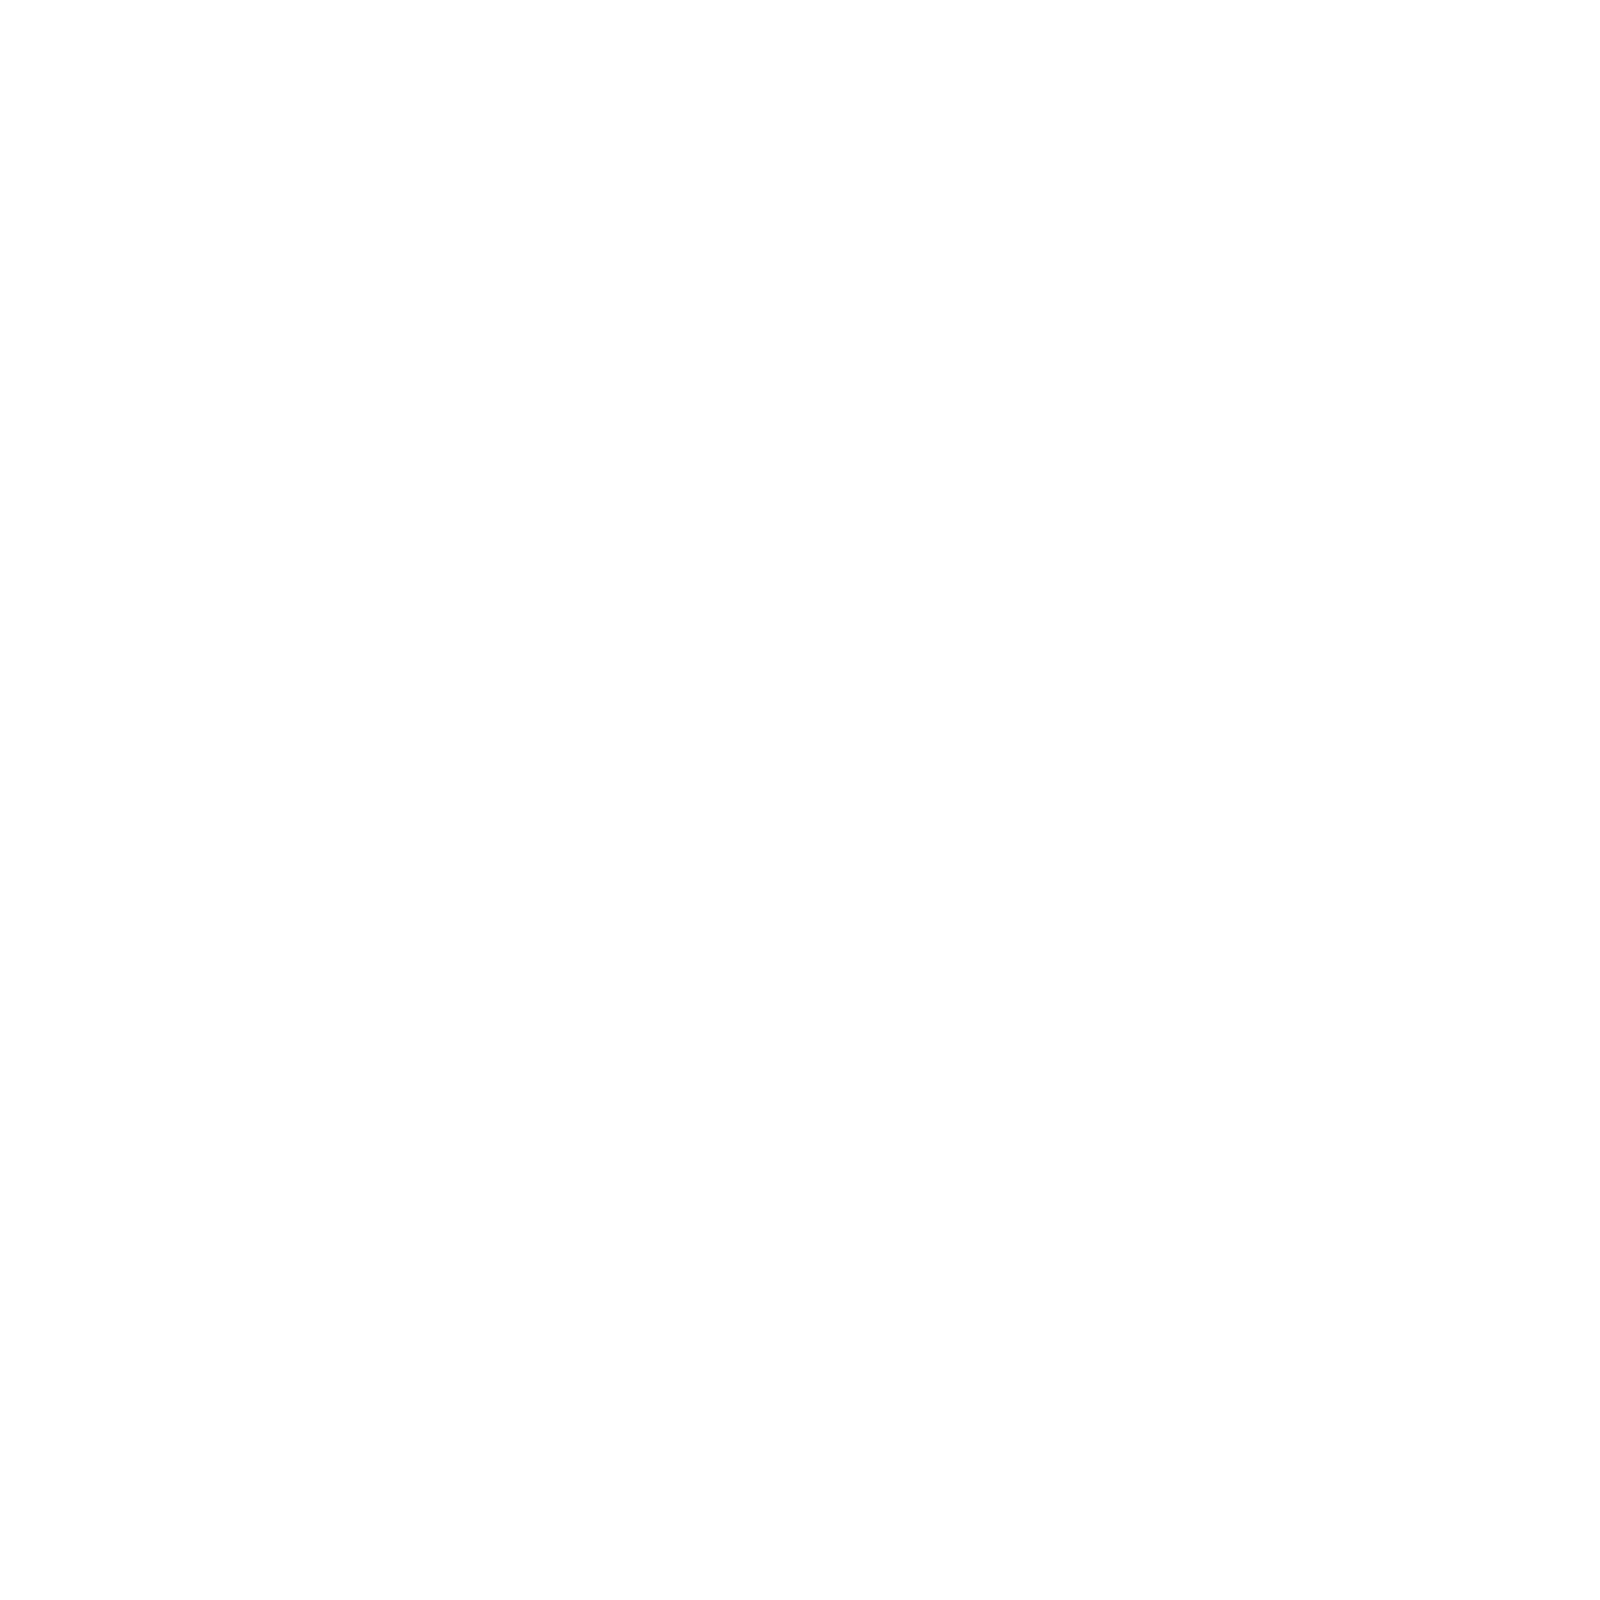

In [60]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC["PC1_CD"]
       , df_PC["PC2_CD"]
       , c = 'r'
       , s = 50)

ax.scatter(df_PC["PC1_UC"]
       , df_PC["PC2_UC"]
       , c = 'g'
       , s = 50)

ax.scatter(df_PC["PC1_nonIBD"]
      , df_PC["PC2_nonIBD"]
      , c = 'b'
      , s = 50)

ax.legend(Diagnosis)
ax.grid()

In [61]:
d_3D={"PC1_CD":CD_ans.T[0] ,"PC2_CD":CD_ans.T[1],"PC3_CD":CD_ans.T[2],
   "PC1_UC":UC_ans.T[0] ,"PC2_UC":UC_ans.T[1],"PC3_UC":UC_ans.T[2],
   "PC1_nonIBD":nonIBD_ans.T[0] ,"PC2_nonIBD":nonIBD_ans.T[1],"PC3_nonIBD":nonIBD_ans.T[2]}

In [62]:
df_PC_3D = pandas.DataFrame(d_3D)

<IPython.core.display.Javascript object>


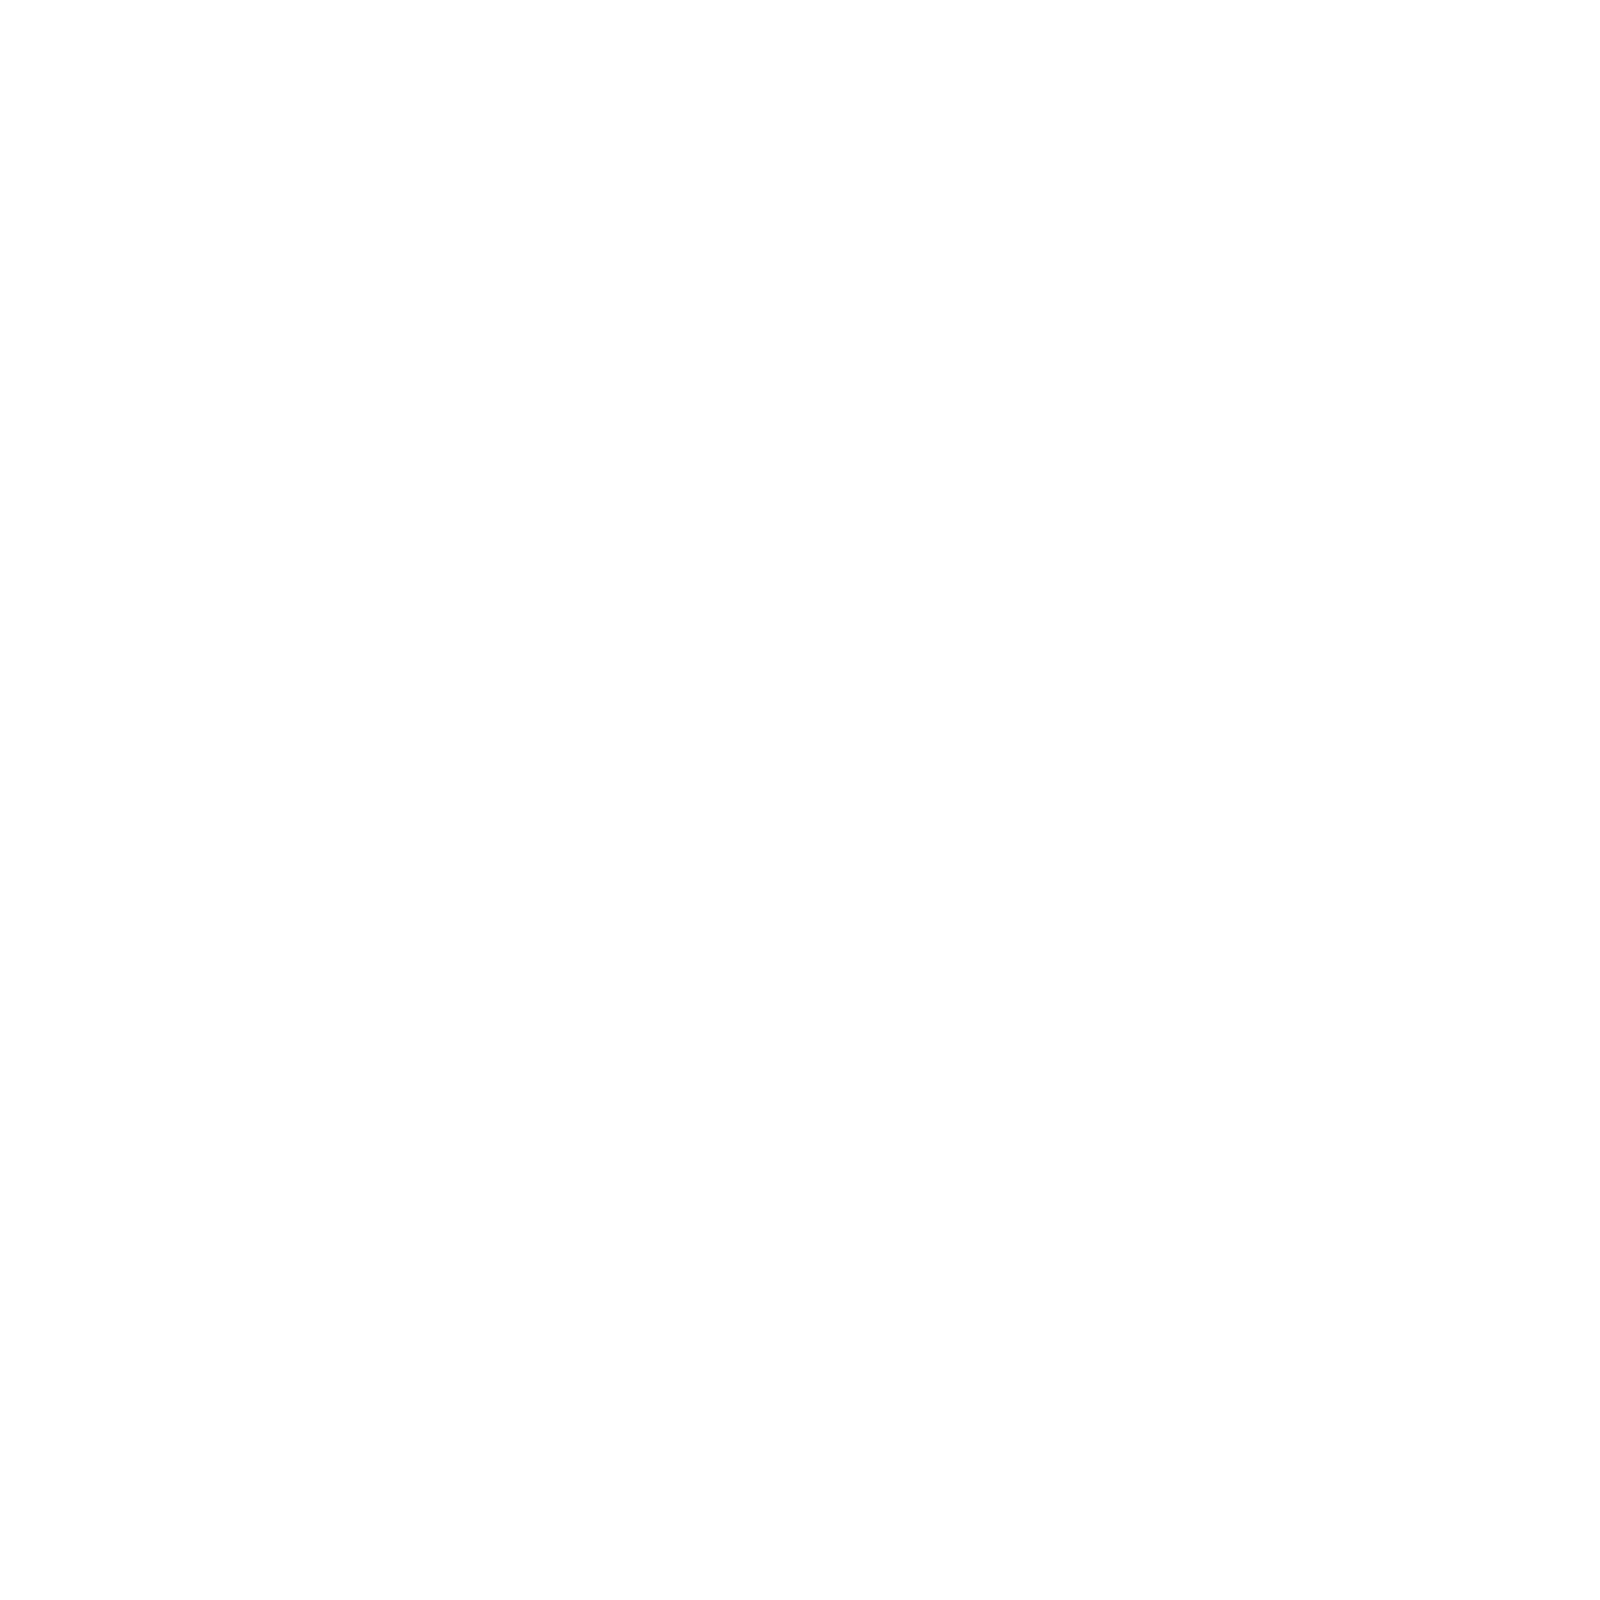

In [63]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(df_PC_3D["PC1_CD"]
       , df_PC_3D["PC2_CD"]
        , df_PC_3D["PC3_CD"]
       , c = 'r')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)
ax.legend('CD')


ax = fig.add_subplot(132, projection='3d')
ax.scatter(df_PC_3D["PC1_nonIBD"]
      , df_PC_3D["PC2_nonIBD"]
        ,df_PC_3D["PC3_nonIBD"]
      ,c = 'b')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)
ax.legend('nonIBD')


ax = fig.add_subplot(133, projection='3d')
Diagnosis = ['CD', 'UC', 'nonIBD']
ax.scatter(df_PC_3D["PC1_UC"]
       ,df_PC_3D["PC2_UC"]
        ,df_PC_3D["PC3_UC"]
       , c = 'g')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)
ax.legend('UC')


<IPython.core.display.Javascript object>


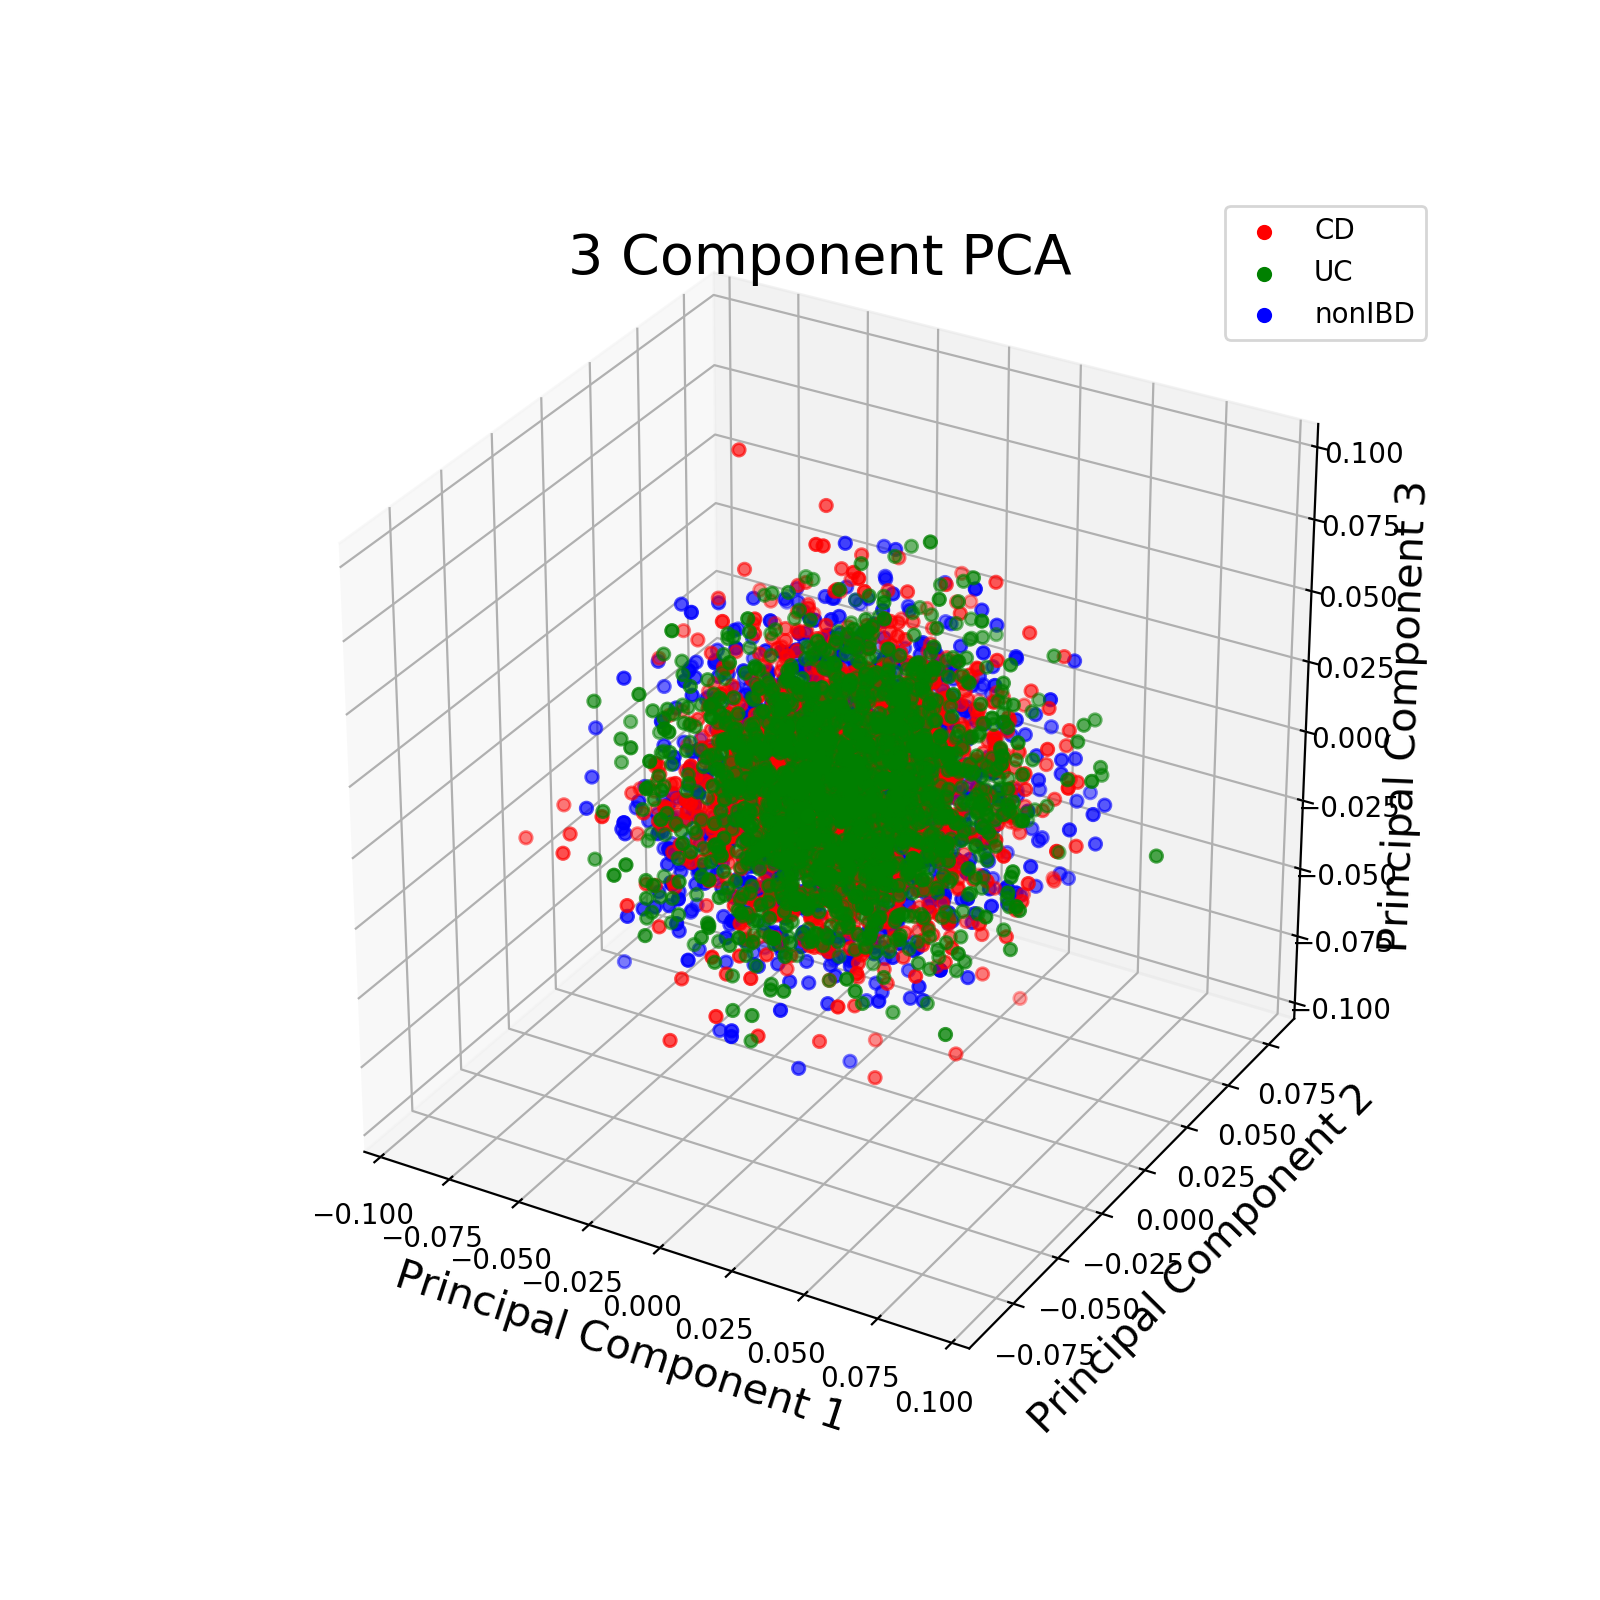

In [64]:
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC_3D["PC1_CD"]
       , df_PC_3D["PC2_CD"]
        , df_PC_3D["PC3_CD"]
       , c = 'r')

ax.scatter(df_PC_3D["PC1_UC"]
       ,df_PC_3D["PC2_UC"]
        ,df_PC_3D["PC3_UC"]
       , c = 'g')
ax.scatter(df_PC_3D["PC1_nonIBD"]
      , df_PC_3D["PC2_nonIBD"]
        ,df_PC_3D["PC3_nonIBD"]
      ,c = 'b')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)
ax.legend(Diagnosis)
ax.grid()

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

<IPython.core.display.Javascript object>


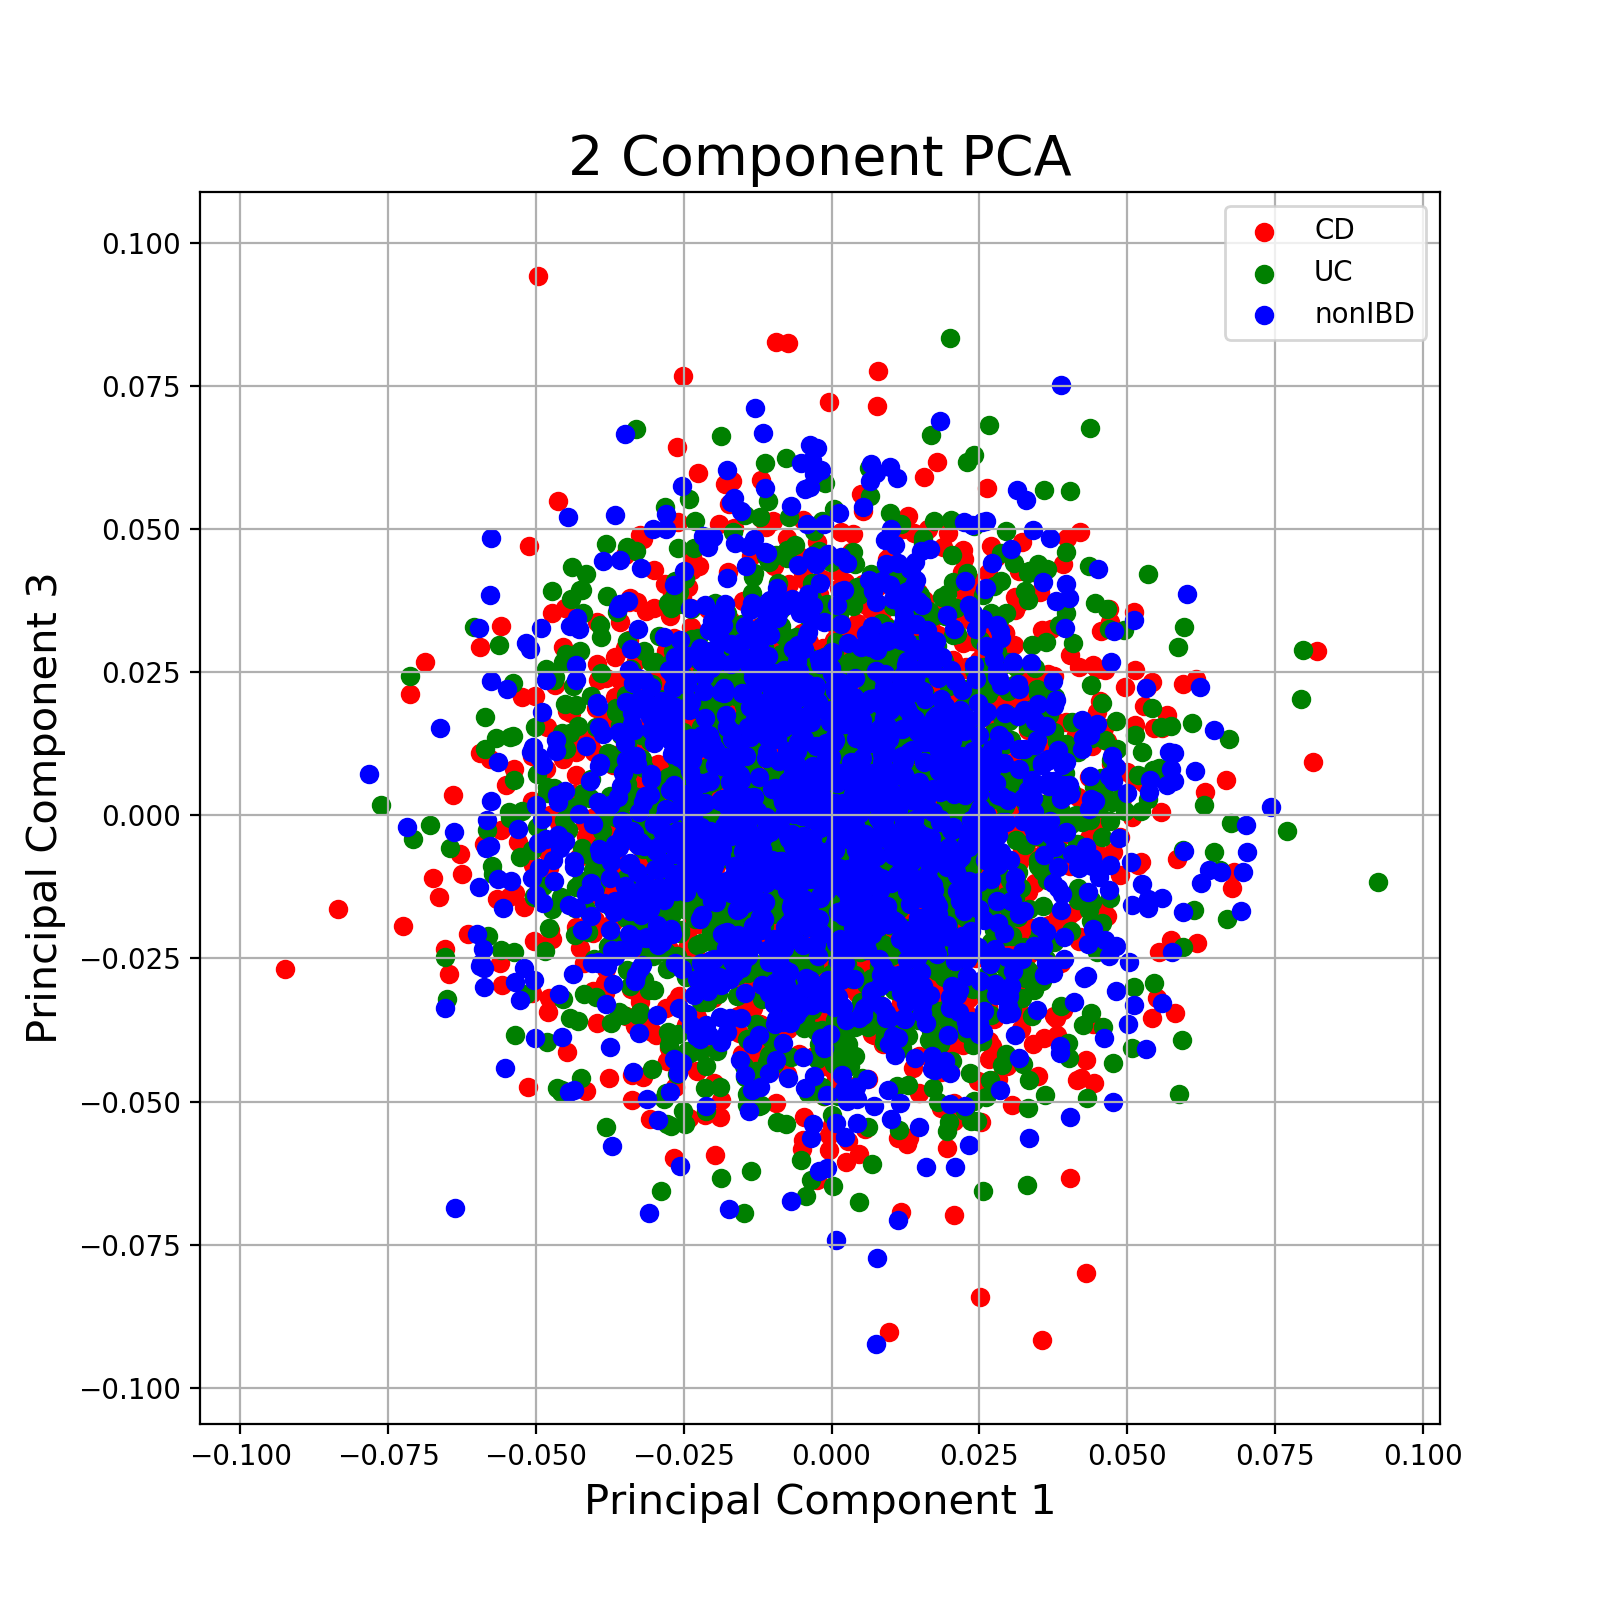

In [65]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC_3D["PC1_CD"]
        ,df_PC_3D["PC3_CD"]
        ,c = 'r')

ax.scatter(df_PC_3D["PC1_UC"]
        ,df_PC_3D["PC3_UC"]
        ,c = 'g')
ax.scatter(df_PC_3D["PC1_nonIBD"]
        ,df_PC_3D["PC3_nonIBD"]
        ,c = 'b')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.legend(Diagnosis)
ax.grid()

<IPython.core.display.Javascript object>


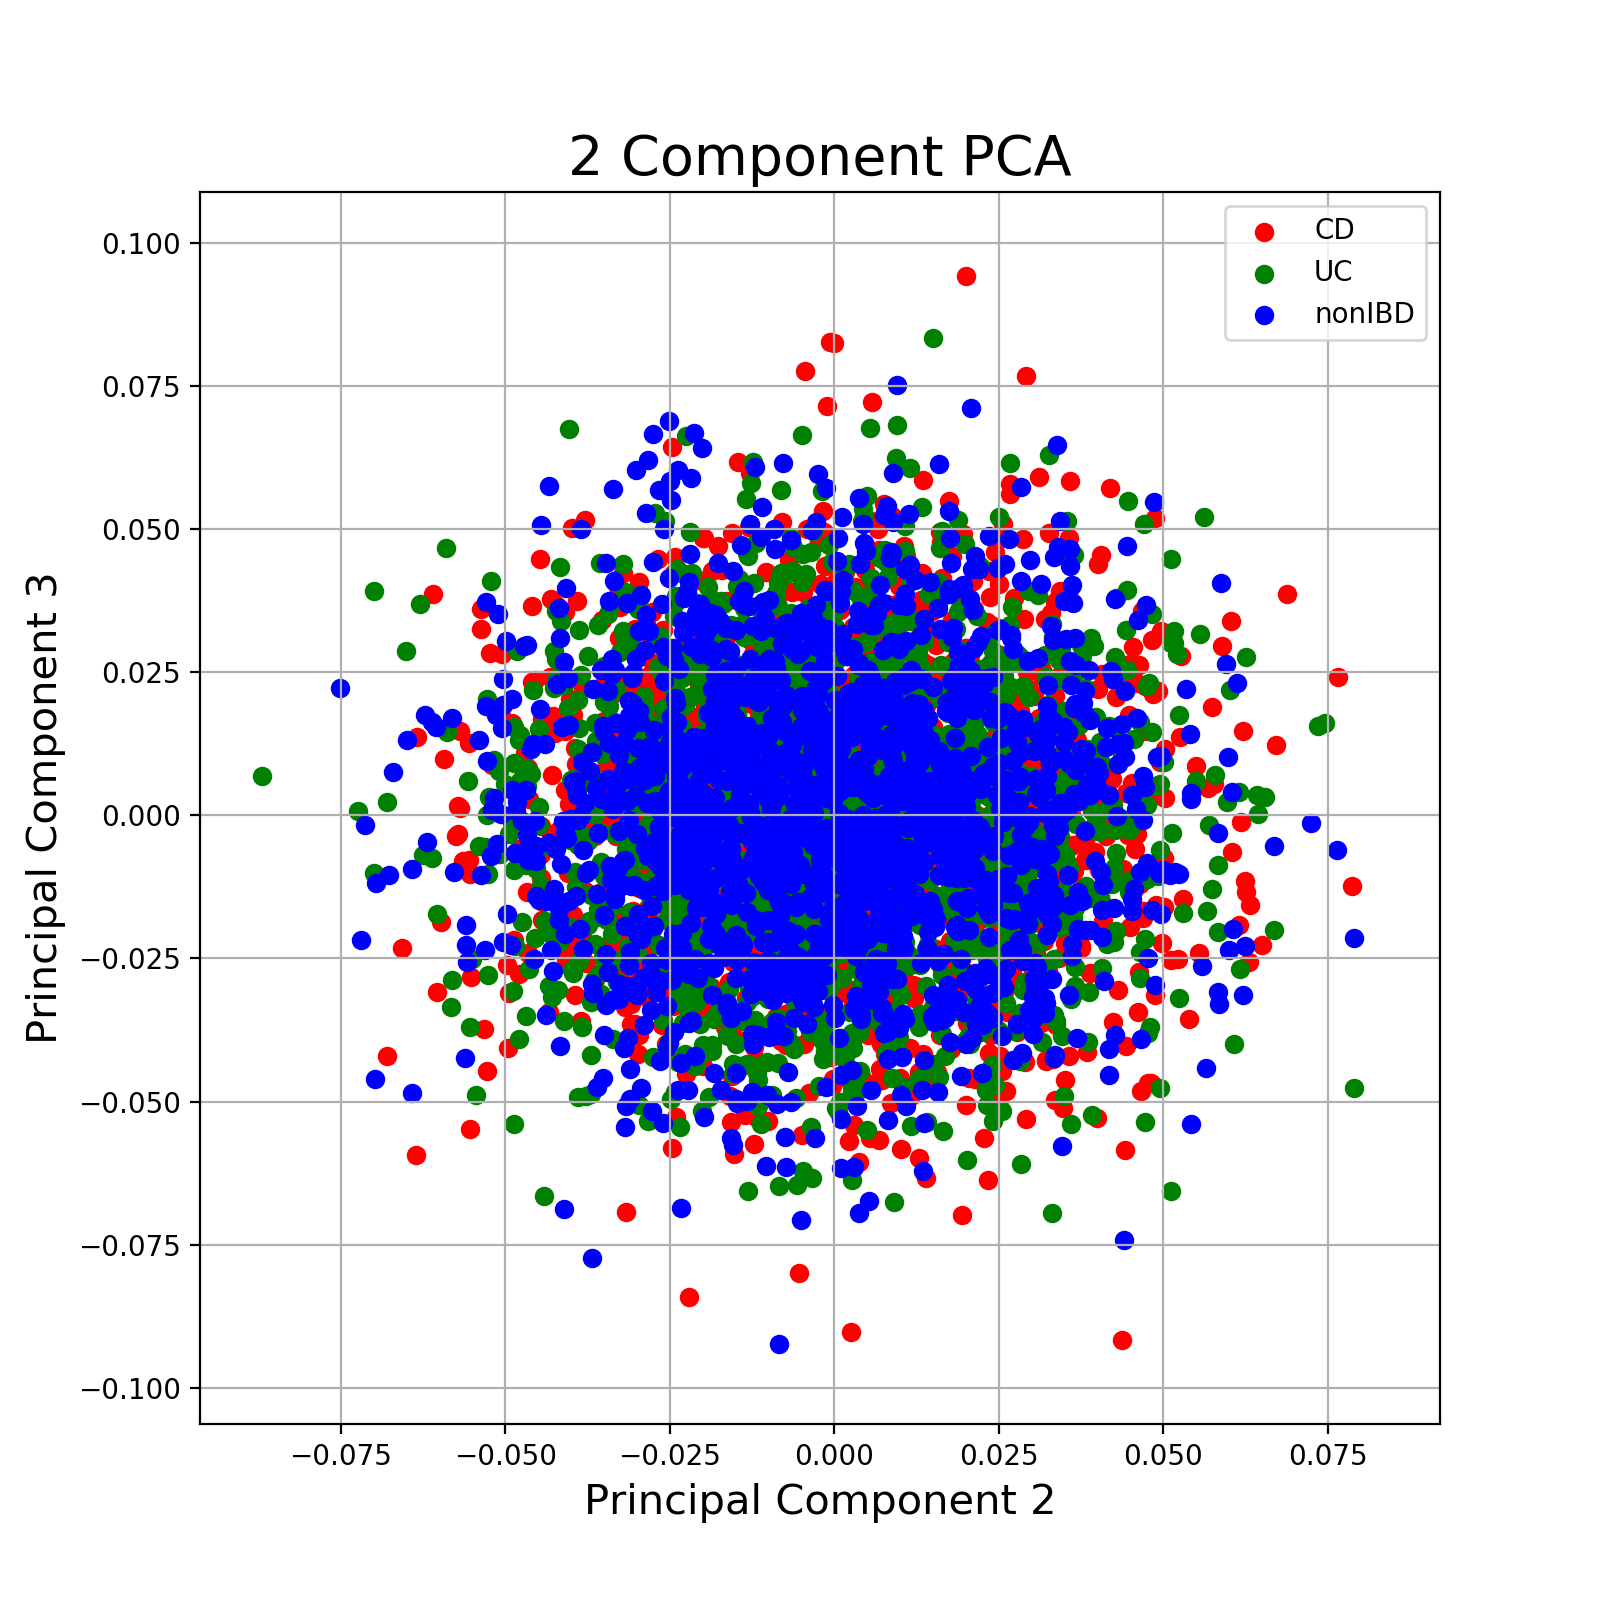

In [66]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC_3D["PC2_CD"]
        ,df_PC_3D["PC3_CD"]
       , c = 'r')

ax.scatter(df_PC_3D["PC2_UC"]
        ,df_PC_3D["PC3_UC"]
       , c = 'g')
ax.scatter(df_PC_3D["PC2_nonIBD"]
        ,df_PC_3D["PC3_nonIBD"]
      , c = 'b')

ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.legend(Diagnosis)
ax.grid()